# Resting-State EEG Aperiodic Exponent Moderates the Association Between Age and Memory Performance in Older Adults

## Initial Setup
---
Conda Environment Explanation:
- This project uses a Conda environment to manage dependencies and ensure reproducibility.
- A Conda environment is an isolated workspace that:
    - Contains specific Python versions and packages
    - Prevents/solves version conflicts between projects
    - Allows clean dependency tracking through environment.yml files (also manages non-Python dependencies i.e., R libraries, HDF5)
- Separate environments act like "lab notebooks" for computational experiments  
- Prevents "dependency hell" when combining domain-specific toolkits  
- Aligns with FAIR principles for open science (reproducible environments)  
- Typical pattern: 1 environment per major processing stage (acquisition/analysis/ML)
---
Create similar environment 
1. Install Conda Distribution
    - Anaconda (4GB): 1500+ preinstalled data science packages in the base env
2. Create EEG Environment:
    - conda create -n eeg_env python=3.9 mne=1.6.0 fooof=1.1.0 pandas=2.0.3
    - conda activate eeg_env
3. Install Project-Specific Packages:
    - pip install neurokit2  # Example EEG package not in conda-forge

In [1]:
import mne  # Main EEG processing library (loading, filtering, visualization)
import seaborn as sns  # Statistical visualization
import numpy as np  # Numerical computing
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Core plotting library

# EEG-Specific Tools
from fooof import FOOOF  # Parametric spectral analysis
from fooof.plts.spectra import plot_spectrum  # Power spectrum visualization

# System/Utility Imports
import os  # File system operations
import warnings  # Handling warnings

# Suppress Non-Critical Warnings for Cleaner Notebook Output
# (Use cautiously - remove during development to see potential issues)
warnings.filterwarnings("ignore")

# Set working directory to project root for consistent file paths
os.chdir('/Users/aliciacampbell/Documents/GitHub/EEG-pyline')  # Update this path for your system

# Import Custom Modules (organized project structure)
import basic.arrange_data as arrange  # Data organization utilities
import signal_processing.pre_process_v2 as pre_process  # Raw EEG preprocessing
import signal_processing.spectral_analysis as spectr  # Frequency analysis

/var/folders/95/f3htk0m94_s3mx1kpf0yrvk80000gn/T/ipykernel_50133/3953717405.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF  # Parametric spectral analysis


**Locating the EEG files in folders** by define the experiment sub-folder (`exp_folder`), folder with raw EEG files (`raw_folder`), folder for exporting clean EEG files (`clean_folder`), and folder for exporting the results (`results_folder`).

During pre-processing, all the raw EEG files are cleaned from the `raw_folder/exp_folder` and later saved to `clean_folder/exp_folder`. For analysis, the same clean files are read in and worked on until the results are exported to `results_folder/exp_folder`.

In [2]:
### DEFINE ###
raw_folder = 'Data/Raw/'
clean_folder = 'Data/Clean/'
spectra_folder = 'Data/Spectra/'
results_folder = 'Results/'
savefinal_folder = 'Results/LEISURE/'

exp_folder = 'LEISURE/T1/EC/tutorial'
exp_condition = 'EC_T1'

## Pre-processing

**Pre-processing** within this study includes initially reading the raw EEG files from `raw_folder/exp_folder`, setting montage (`biosemi32`), re-referencing the signal, cropping the EEG signal to include only the `resting` part.

Furthermore, `0.5-30 Hz FIR filter` is designed (`zero-phase, Hamming window, order 6578`) and EOG channels are used to remove EOG-related noise with `signal-space projections (SSP)` as method.

Finally, artefacts are rejected with Autoreject package by removing epochs which exceed the global thereshold voltage level (`global AR`) and rest of the artefactual epochs are either removed or interpreted with `local AR`.

The clean EEG signals are exported to `clean_folder/exp_folder`.

Global field potential (gfp) plots post AR are exported to `temp/exp_folder` to visually inspect.

In [3]:
### DATA PREPARATION PIPELINE ###

# Montage Configuration
# ---------------------
montage = 'biosemi32'  # Standard 32-channel BioSemi layout
verbose = False

other_ch = {
    'mastoid': ['EXG1', 'EXG2'],
    'heog': ['EXG3', 'EXG4'],
    'veog': ['EXG5', 'EXG6'],
    'misc': ['EXG7', 'EXG8']
}
all_other_ch = other_ch['mastoid']+other_ch['heog']+other_ch['veog']+other_ch['misc']

stimulus_channel = 'Status'  # Event marker channel
erg_channel = 'Erg1'  # Auxiliary input channel (I had a respiration effor sensor for a meditation task)
reference = 'average'  # Using average reference 

# Epoch Parameters
epochs_duration = 5  # 5-second epochs for spectral analysis

# Filter Design (FIR bandpass 0.5-30Hz)
filter_design = dict(
    l_freq=0.5,  # High-pass cutoff
    h_freq=30,   # Low-pass cutoff 
    filter_length='auto',  # Let MNE determine optimal length
    method='fir',  # Finite Impulse Response filter
    l_trans_bandwidth='auto',  # Automatic transition band
    h_trans_bandwidth='auto',
    phase='zero',  # Zero-phase distortion (non-causal)
    fir_window='hamming',  # Window for FIR design
    fir_design='firwin'  # FIR filter design method
)

# Channel Renaming Configuration
# -----------------------------
# Biosemi specific - 
# Mapping hardware channels to standard names (some of my EEG data contains data with the wrong montage selected)
wrong_mnt_chs = ["B1","B2","B3","B4","B5","B6","B7","B8","B9","B10","B11","B12",
                "B13","B14","B15","B16","B17","B18","B19","B20","B21","B22","B23","B24",
                "B25","B26","B27","B28","B29","B30","B31","B32",
                "C1","C2","C3-1","C4-1","C5","C6","C7","C8","C9","C10","C11","C12",
                "C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24",
                "C25","C26","C27","C28","C29","C30","C31","C32",
                "D1","D2","D3","D4","D5","D6","D7","D8","D9","D10","D11","D12",
                "D13","D14","D15","D16","D17","D18","D19","D20","D21","D22","D23","D24",
                "D25","D26","D27","D28","D29","D30","D31","D32"]

# File Path Management
# --------------------

# Construct full paths
dir_inprogress = os.path.join(raw_folder, exp_folder)  # Input: raw/experiment1/
export_dir = os.path.join(clean_folder, exp_folder)   # Output: processed/experiment1/

# Create output directory (if doesn't exist)
os.makedirs(export_dir, exist_ok=True)  # Safe directory creation

# File Discovery
# --------------
subject_name = 'HBA_0001_EC_T1'
file_dir = f'Data/Raw/LEISURE/T1/EC/tutorial/{subject_name}.bdf'

Reading 0 ... 452607  =      0.000 ...   441.999 secs...
Datapoints and IDs of the events:
[[188237      0      1]
 [188339      0      8]
 [434011      0      2]]
Starting point sample: 188339
Ending point sample: 434011
Raw signal length = 239.9140625 s
2 projection items deactivated
Created an SSP operator (subspace dimension = 2)
2 projection items activated
SSP projectors applied...


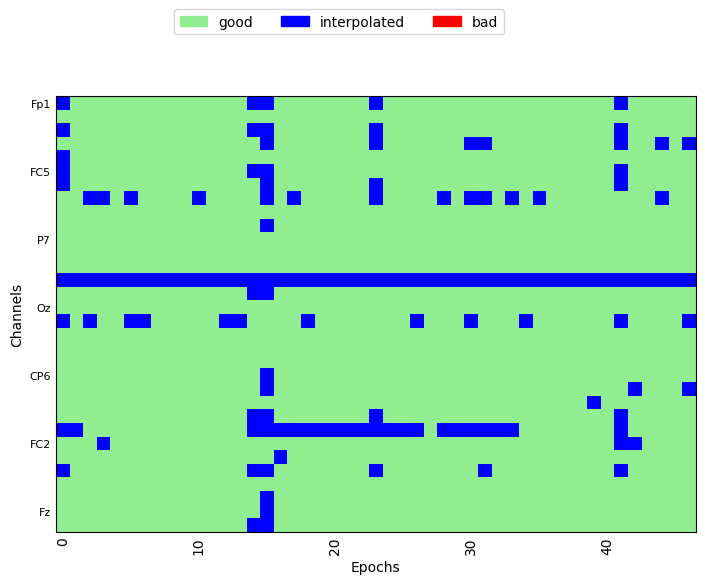

ALL GOOD! more than half of epochs after AR (47/47)
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


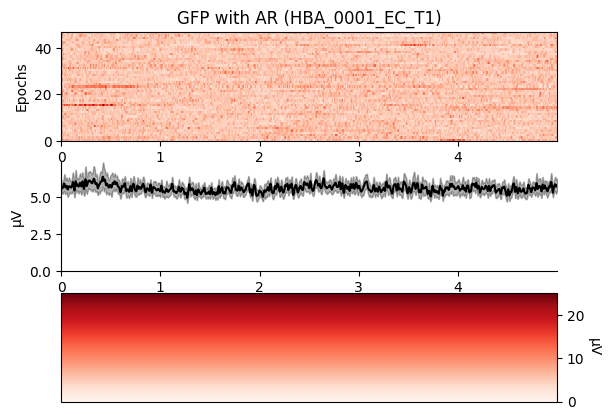

Using matplotlib as 2D backend.


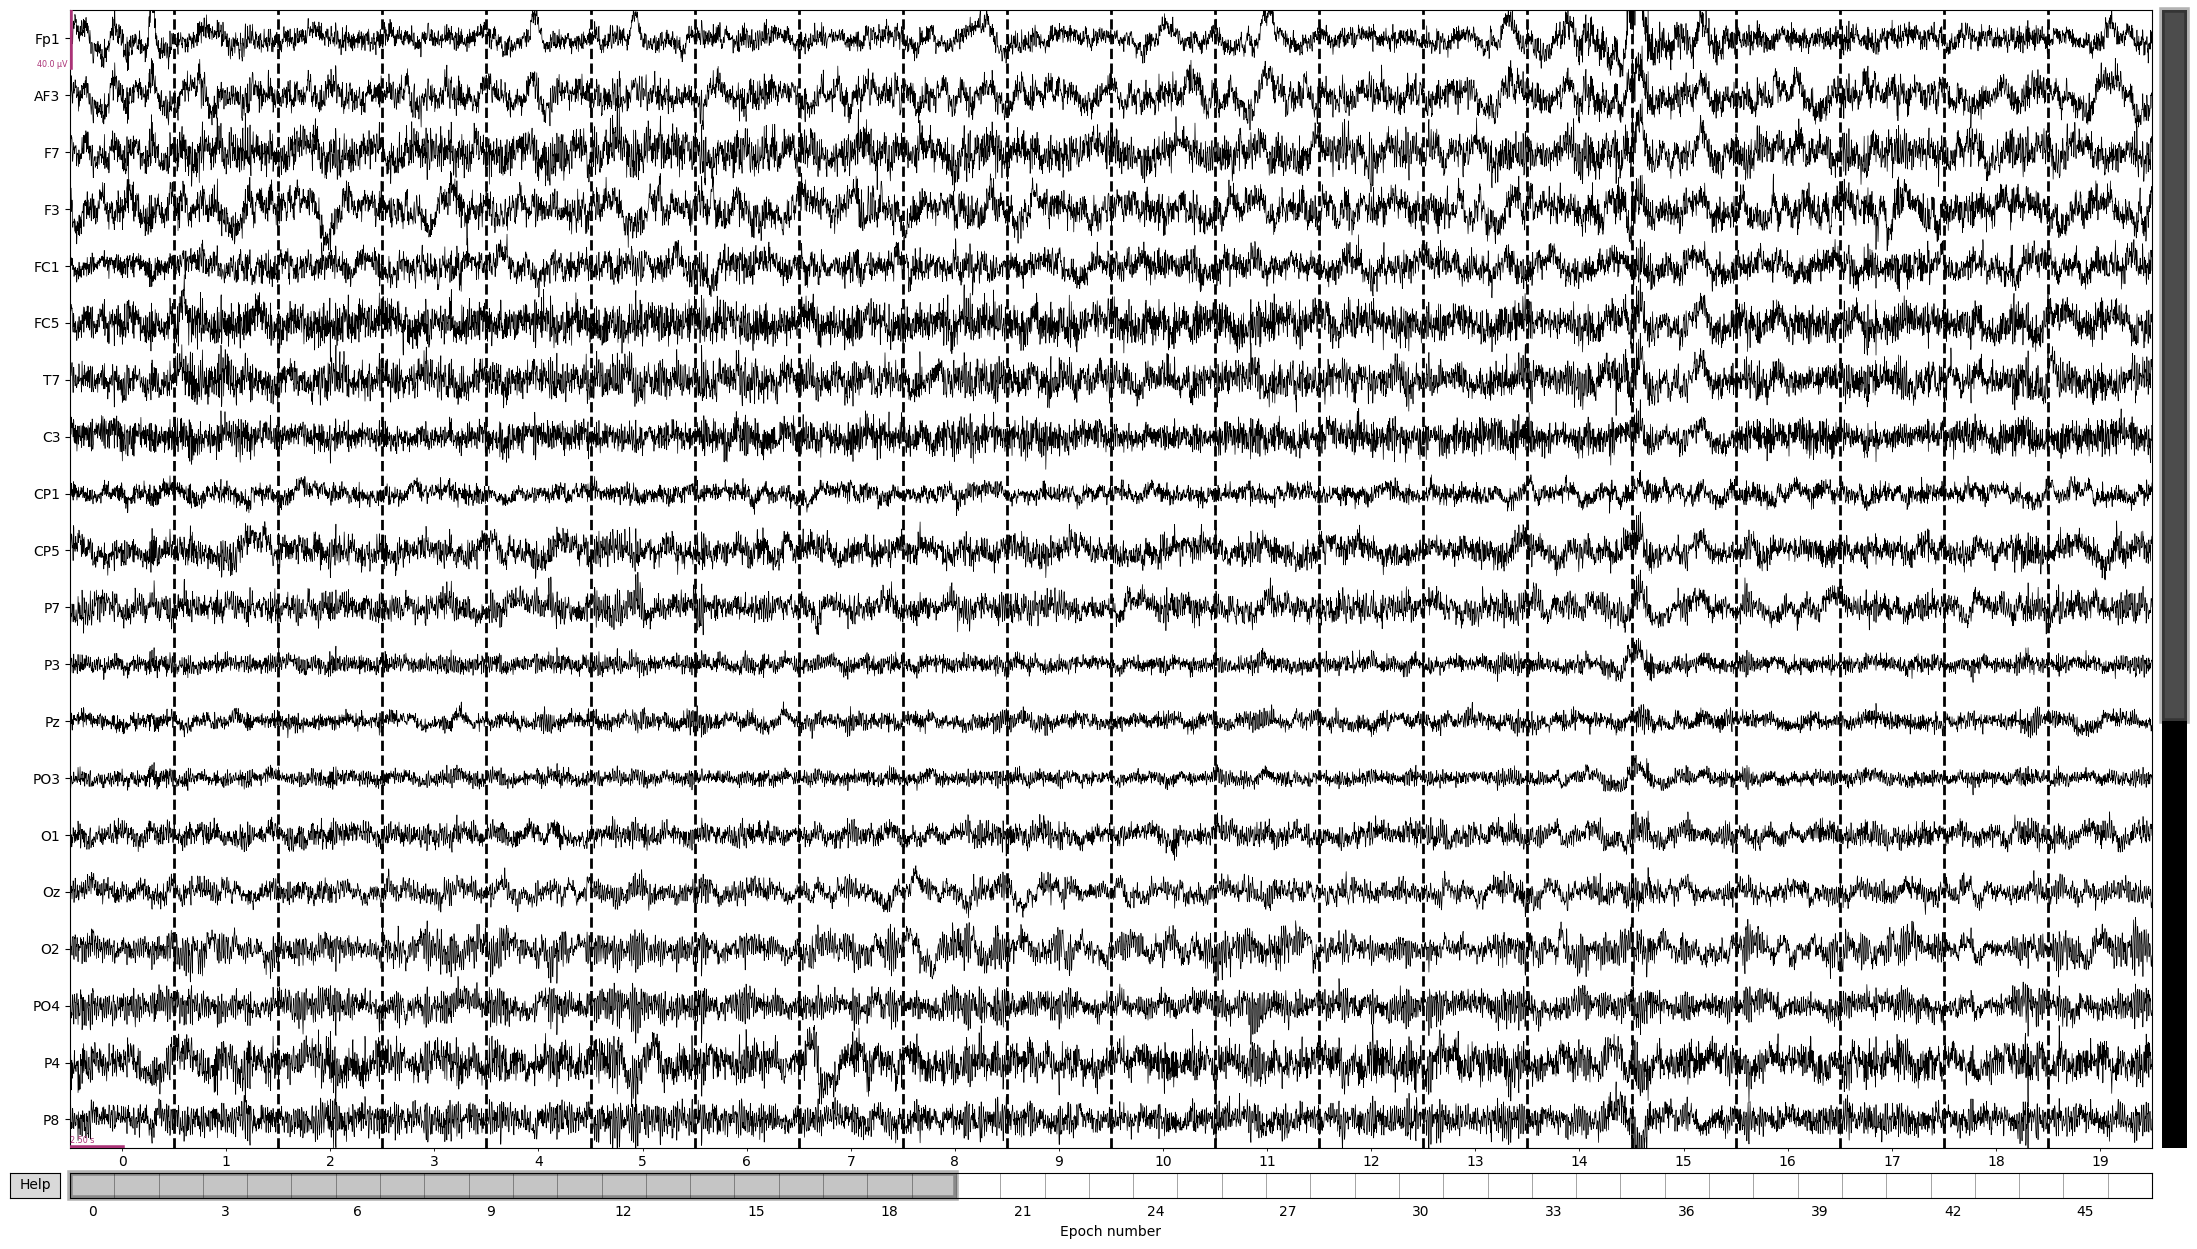

In [4]:
# === DATA IMPORT AND BASIC CHANNEL MANAGEMENT ===
# Read BDF file with automatic type inference, specifying EOG channels and stimulus channel
raw = mne.io.read_raw_bdf(file_dir, infer_types=True, eog=all_other_ch,
                            stim_channel=stimulus_channel, verbose=verbose)

# Remove Erg1 channel if present
if 'Erg1' in raw.info['ch_names']:
    print('Erg1 channel detected and dropping..')
    raw = raw.drop_channels(['Erg1'])

# Correct montage issues by removing bad channels and standardizing naming
if len(set(wrong_mnt_chs).intersection(set(raw.info['ch_names']))) > 0:
    print('Wrong montage, removing bad channels and replacing some channel names..')
    print('C-channels before:', [c for c in raw.info['ch_names'] if c.startswith('C')])
    raw = raw.drop_channels(wrong_mnt_chs).rename_channels({'C3-0':'C3','C4-0':'C4'})
    print('C-channels after:', [c for c in raw.info['ch_names'] if c.startswith('C')])

# === MONTAGE SETUP AND REFERENCING ===
# Apply standard BioSemi32 montage and set average reference
raw = raw.set_montage(mne.channels.make_standard_montage(montage), verbose=verbose).load_data()\
            .set_eeg_reference(ref_channels=reference, verbose=verbose)

# === EVENT DETECTION ===
# Find stimulus events with offset output (sample numbers relative to recording start)
events = mne.find_events(raw, stim_channel=stimulus_channel, consecutive=False, output='offset', verbose=verbose)
print(f'Datapoints and IDs of the events:\n{events}')

def find_event_pair(events, start_id, end_id):
    """Finds first occurrence of consecutive event markers (start_id followed by end_id)
    Returns tuple of (start_sample, end_sample) or (None, None) if not found"""
    for i in range(len(events)):
        if events[i][2] == start_id:
            start_sample = events[i][0]
            # Find the next occurrence of end_id
            for j in range(i + 1, len(events)):
                if events[j][2] == end_id:
                    end_sample = events[j][0]
                    return start_sample, end_sample
    return None, None  # Return None if no valid pair is found

# Find resting state period markers (custom IDs 8=start, 2=end)
s_minmax = find_event_pair(events, start_id=8, end_id=2)
if s_minmax[0] and s_minmax[1]:
    print(f"Starting point sample: {s_minmax[0]}")
    print(f"Ending point sample: {s_minmax[1]}")
else:
    print("No valid event pair (8->2) found.")

# === DATA TRIMMING AND QUALITY CHECK ===
# Convert samples to time and crop data to resting state segment
if s_minmax[0] != None and s_minmax[1] != None:
    t_minmax = [s_minmax[0]/raw.info['sfreq'], s_minmax[1]/raw.info['sfreq']]
    raw_c = raw.crop(tmin=t_minmax[0], tmax=t_minmax[1])
    
    # Validate recording duration (4 mins ±20s)
    tlen = t_minmax[1] - t_minmax[0]
    if (230 <= tlen <= 250) == True:
        print(f'Raw signal length = {tlen} s')
    else:
        print(f'WARN: Raw signal length = {tlen} s (i.e. not between 230-250 s)')
    
    # Remove stimulus channel after cropping
    raw_c = raw_c.drop_channels(stimulus_channel)
else:
    print(f'WARN: No cropping done.')
    raw_c = raw.copy()

# === SIGNAL PROCESSING PIPELINE ===
# Apply bandpass filter (likely 0.5-40Hz) and SSP for EOG artifact removal
filt = pre_process.filter_raw_data(raw_c, filter_design, line_remove=None, other_ch=other_ch, 
                                    plot_filt=False, savefig=False, verbose=verbose)

# === EPOCHING AND ARTIFACT REJECTION ===
# Enable inline plotting for Jupyter Notebook
# %matplotlib inline  

# Create epochs and apply Autoreject (duration typically 2-4s)
epochs = pre_process.artefact_rejection(filt, subject_name, epo_duration=epochs_duration,
                                        pltfig=True, savefig=False, verbose=verbose)

# Visualize final epochs
epochs.plot()
plt.show()

# %matplotlib qt
# epochs.plot(n_channels=32,n_epochs=1)

# Optional saving of cleaned epochs (commented out)
# mne.Epochs.save(epochs,fname='{}/{}_clean-epo.fif'.format(export_dir,subject_name), overwrite=True)

In [ ]:
### DEFINE

# Define frequency bands of interest (Alpha rhythm here)
bands = {'Alpha' : [7, 14]}

# Define region clusters and their corresponding EEG electrodes
brain_regions = {'Parieto-occipital' : ['P3', 'Pz', 'P4', 'PO3', 'PO4', 'O1', 'O2', 'Oz'],
                 'Fronto-central': ['F3', 'F4', 'Fz']}

# Spectral visualization type: 
# 'linear_flat' = aperiodic-corrected linear spectrum
# 'log_flat' = aperiodic-corrected log spectrum
# Options with '_normal' show raw spectrum without aperiodic correction
ind_spectr_type = 'linear_flat' # linear_normal, _normal, 'linear_flat', log_flat
plot_rich = True

# PSD calculation parameters using Welch's method
psd_params = dict(
    method='welch', 
    fminmax=[1, 30], 
    window='hamming',       # Taper window to reduce spectral leakage
    window_duration=2.5,    # Epoch duration in seconds 
    window_overlap=0.5,     # 50% overlap between segments
    zero_padding=39         # Increases frequency resolution through zero-padding
)

# FOOOF model parameters for spectral decomposition
fooof_params = dict(
    peak_width_limits=[1,12],   # Range of valid peak widths (Hz)
                                    # Accommodates alpha variability (typically 4-10Hz width)
    max_n_peaks=float("inf"),   # No limit on number of detectable peaks
                                    # Lets data determine number of peaks rather than imposing limits
    min_peak_height=0.05,       # Absolute threshold for peak detection (absolute aperiodic threshold in log-power)
                                    # 0.05 min height: Rejects tiny peaks in log space (equivalent to ~10% power difference in linear space)
    peak_threshold=2.0,         # Relative threshold (std) for peak detection (peaks must be >2SD above noise floor)
                                    # 2.0 peak threshold: Robust against false positives
    aperiodic_mode='fixed'      # Model 1/f background as offset + exponent ( fixed = single 1/f)
)                               # You can also add the option of adding a 'knee' if your data
                                    # has a promintent knee (frequency where slope changes)
                                    # Broad frequency ranges (> ~40 Hz range) typically do not have a single 1/f as they typically exhibit a ‘bend’ in the aperiodic component. 
                                    # This indicates that there is not a single 1/f property across all frequencies, but rather a ‘bend’ in the aperiodic component. 
                                    # For these cases, fitting should be done using an extra parameter to capture this, using the ‘knee’ mode.

# Generate unique spectrum name based on analysis parameters
spectrum_name = psd_params['method']+'_'+str(psd_params['fminmax'][0])+'-'+str(psd_params['fminmax'][1])+'Hz_WIN='+str(
                psd_params['window_duration'])+'s_'+psd_params['window']+'_OL='+str(psd_params['window_overlap']*
                100)+'%_ZP='+str(psd_params['zero_padding']*psd_params['window_duration'])+'s'

# Set visualization style
sns.set_palette('muted')
sns.set_style("whitegrid")

In [11]:
### PROCESS

# Calculate Welch's power spectrum density using specified parameters
[psds,freqs] = spectr.calculate_psd(epochs, subject_name, method=psd_params['method'],
                                    fminmax=psd_params['fminmax'], window=psd_params['window'],
                                    window_duration=psd_params['window_duration'],
                                    window_overlap=psd_params['window_overlap'],
                                    zero_padding=psd_params['zero_padding'],
                                    verbose=True, plot=False)

# # Average PSD across all epochs for each channel and also for each region and organize into DataFrames
psds = psds.mean(axis=(0))
df_psds_ch = arrange.array_to_df(subject_name, epochs, psds).reset_index().drop(columns='Subject')
df_psds_regions = arrange.df_channels_to_regions(df_psds_ch, brain_regions).reset_index().drop(columns='Subject')

---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 47 epochs × 32 channels × 2901 freqs, 1.0-30.0 Hz>
Time period: [None, None]
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 99840

Samples per segment: 2560
Samples for FFT: 102400
Frequency resolution: 0.010000000000000009 Hz


  Peak Parameters 	 Gaussian Parameters
 8.73  0.42  1.18 	  8.73  0.35  0.59
10.11  1.22  1.00 	 10.11  0.80  0.50
10.86  0.80  1.91 	 10.86  0.51  0.96
15.83  0.20  5.12 	 15.83  0.19  2.56
20.68  0.62  3.29 	 20.68  0.59  1.64


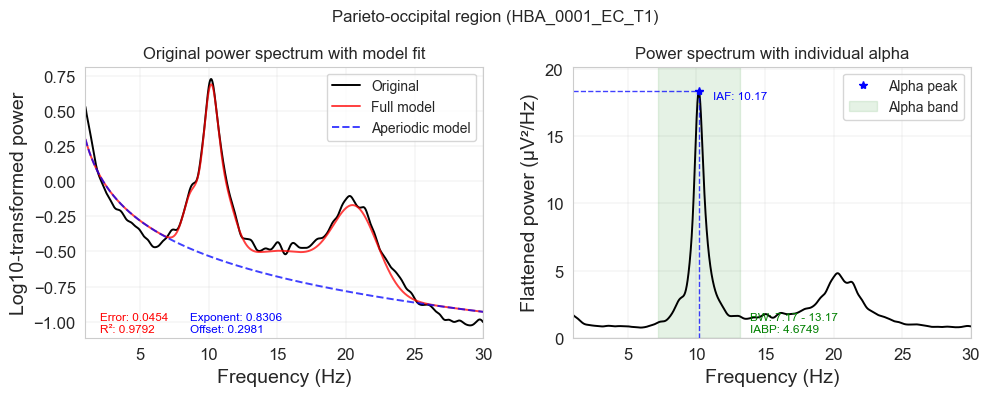

  Peak Parameters 	 Gaussian Parameters
 7.57  0.17  1.00 	  7.57  0.16  0.50
10.09  0.38  1.60 	 10.09  0.38  0.80
12.79  0.14  1.00 	 12.79  0.11  0.50
15.93  0.23  3.27 	 15.93  0.22  1.63
19.99  0.58  2.91 	 19.99  0.56  1.45
21.83  0.48  1.54 	 21.83  0.21  0.77
23.63  0.23  1.80 	 23.63  0.19  0.90


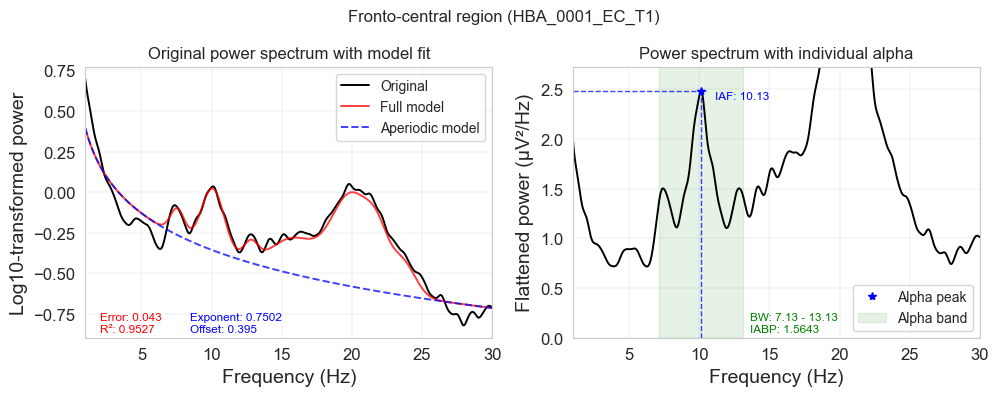

,exponent,offset,alpha_cf,alpha_pw,alpha_bw,alpha_abs_bp,alpha_rel_bp,r_squared,error
Parieto-occipital,0.830563,0.298114,10.17,18.353821,"[7.17, 13.17]",4.674877,2.063351,0.979249,0.045350
Fronto-central,0.750209,0.394996,10.13,2.478183,"[7.13, 13.13]",1.564267,0.943479,0.952667,0.043046


In [20]:
# Initialize DataFrame for storing FOOOF results
df_fooof = pd.DataFrame()

gaussian_params = []
peak_params = []
region_labels = []

# Process each brain region separately
for region in df_psds_regions.columns:
    psds_temp = df_psds_regions[region].to_numpy()

    # Fit spectrum using FOOOF model to separate periodic and aperiodic components
    fm = FOOOF(**fooof_params, verbose=True)                # Initialize a FOOOF object
    fm.fit(freqs, psds_temp, psd_params['fminmax'])         # Fit the model with FOOOF
        
    # Convert spectrum based on selected type (linear vs log scale)
    if ind_spectr_type == 'linear_flat':                     # Aperiodic-removed spectrum in linear space       
        flatten_spectrum = 10 ** fm._spectrum_flat
        flat_spectr_ylabel = 'Flattened power (µV\u00b2/Hz)'
    elif ind_spectr_type == 'log_flat':                      # Aperiodic-removed spectrum in log space
        flatten_spectrum = fm._spectrum_flat
        flat_spectr_ylabel = 'Flattened log10-transformed power'
    elif ind_spectr_type == 'linear_normal':                 # Raw PSD (periodic + aperiodic)
        flatten_spectrum = psds_temp
        flat_spectr_ylabel = 'Power (µV\u00b2/Hz)'
    elif ind_spectr_type == 'log_normal':                    # Log-transformed raw PSD
        flatten_spectrum = np.log10(psds_temp)
        flat_spectr_ylabel = 'Log10-transformed power'

    # Peak detection in flattened spectrum
    cf, pw, bw, abs_bp, rel_bp = spectr.find_ind_band(flatten_spectrum, freqs,
                                                        bands['Alpha'], bw_size=6)
        # `cf` - Center Frequency (Individual Alpha Frequency, IAF)
            # Center frequency of the extracted peak (alpha oscillations within the specified band (Hz))
        # `pw` - Peak Power
            # Power of the peak, over and above the aperiodic component (µV²/Hz)
        # `bw` - Bandwidth
            # Frequency range containing the alpha peak (from `bw_size=6` parameter)
            # IAF - 3Hz, IAF + 3Hz
        # `abs_bp` - Absolute Band Power
            # Total power in individualized alpha band (bw) (µV²)
        # `rel_bp` - Relative Band Power
            # Integrated power across the entire analyzed spectrum (1-30Hz)
            # absolute bp / total power
            # dimensionless ratio (i.e., 0.25 = 25%)

    # Note that the peak parameters that are returned are not exactly the same as the parameters 
    # of the Gaussians used internally to fit the peaks.

        # Specifically:
        # `cf` is the exact same as mean parameter of the Gaussian
        # `pw` is the height of the model fit above the aperiodic component, which is not necessarily the same as the Gaussian height
            # Since the Gaussians are fit together, if any Gaussians overlap, than the actual height of the fit at a given point
            # can only be assessed when considering all Gaussians. To be better able to interpret heights for individual peaks, 
            # "FOOOF" re-defines the peak height as above, and labels it as ‘power’, as the units of the input data are expected to be units of power.
        # `bw` is 2 * the standard deviation of the Gaussian
            # Gaussian standard deviation is ‘1 sided’, where as the returned BW is ‘2 sided’.

    # The underlying gaussian parameters are also available from the FOOOF object, in the gaussian_params_ attribute.
    
    # Compare the 'peak_params_' to the underlying gaussian parameters
    print('  Peak Parameters \t Gaussian Parameters')
    for peak, gauss in zip(fm.peak_params_, fm.gaussian_params_):
        print('{:5.2f} {:5.2f} {:5.2f} \t {:5.2f} {:5.2f} {:5.2f}'.format(*peak, *gauss))
    
    gaussian_params.extend(fm.gaussian_params_)
    peak_params.extend(fm.peak_params_)
    region_labels.extend([region] * len(fm.gaussian_params_))  # Add labels

    # Configure plot styling parameters
    data_kwargs = {'color' : 'black', 'linewidth' : 1.4, 'label' : 'Original'}
    model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75, 'label' : 'Full model'}
    aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                        'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
    flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
    hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

    # Create dual-plot figure for visualization
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=100)
    
    # Left plot: Original spectrum with model fits
    plot_spectrum(fm.freqs, fm.power_spectrum,          # Original power spectrum (log-transformed PSD)
                ax=axs[0], **data_kwargs)
    plot_spectrum(fm.freqs, fm.fooofed_spectrum_,       # Full model fit (aperiodic + periodic components)
                ax=axs[0], **model_kwargs)
    plot_spectrum(fm.freqs, fm._ap_fit,                 # Isolated aperiodic component (1/f background)
                ax=axs[0], **aperiodic_kwargs)
    axs[0].set_xlim(psd_params['fminmax'])
    axs[0].grid(linewidth=0.2)
    axs[0].set_xlabel('Frequency (Hz)')
    axs[0].set_ylabel('Log10-transformed power')
    axs[0].set_title('Original power spectrum with model fit')
    axs[0].legend()
    
    # Right plot: Flattened spectrum with alpha peak analysis
    plot_spectrum(fm.freqs, flatten_spectrum,           # Flattened spectrum (aperiodic component removed)
                ax=axs[1], **flat_kwargs)
    axs[1].plot(cf, pw, '*', color='blue', label='{} peak'.format(list(bands.keys())[0]))   # Star at peak center
    axs[1].set_xlim(psd_params['fminmax'])
    if ind_spectr_type == 'linear_flat' or ind_spectr_type == 'linear_normal': 
        (axs[1].set_ylim([0, pw*1.1]))
    if ind_spectr_type == 'log_flat' or ind_spectr_type == 'log_normal':
        (axs[1].set_ylim([None, pw*1.1]))
    axs[1].axvline(x=cf, ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
    axs[1].axhline(y=pw, xmin=0, xmax=cf/(psd_params['fminmax'][1]+1), **hvline_kwargs)
    axs[1].axvspan(bw[0], bw[1], alpha=0.1, color='green', label='{} band'.format(list(bands.keys())[0]))   # Bandwidth shading
    axs[1].grid(linewidth=0.2)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel(flat_spectr_ylabel)
    axs[1].set_title('Power spectrum with individual alpha')
    axs[1].legend()

    # Add detailed annotations if enabled
    if plot_rich == True:
        axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                    '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                    (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
        axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                    '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                    (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
        axs[1].text(cf+1, pw, 'IAF: '+str(np.round(cf, 4)),
                    verticalalignment='top', color='blue', fontsize=8.5)
        axs[1].annotate('BW: '+str(np.round(bw[0], 4))+' - '+str(np.round(bw[1], 4))+
                        '\nIABP: '+str(np.round(abs_bp, 4)),
                        (0.75, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
    
    plt.suptitle('{} region ({})'.format(region, subject_name))
    plt.tight_layout()
    plt.show()

    # Store extracted parameters in DataFrame
    df_fooof.loc[region, 'exponent'] = fm.get_params('aperiodic_params','exponent') # 1/f slope
    df_fooof.loc[region, 'offset'] = fm.get_params('aperiodic_params','offset')     # y-intercept
    df_fooof.loc[region, 'alpha_cf'] = cf
    df_fooof.loc[region, 'alpha_pw'] = pw
    df_fooof.loc[region, 'alpha_bw'] = str(bw)
    df_fooof.loc[region, 'alpha_abs_bp'] = abs_bp
    df_fooof.loc[region, 'alpha_rel_bp'] = rel_bp
    
    # Goodness of fit measures
    df_fooof.loc[region, 'r_squared'] = fm.get_params('r_squared')                  # The proportion of variance in the power spectrum 
                                                                                        # explained by the FOOOF model (aperiodic + periodic components).
                                                                                        # e.g., If R² = 0.85 → 85% of spectral variance is explained by the model
    df_fooof.loc[region, 'error'] = fm.get_params('error')                          # Sum of squared residuals between observed and modeled spectrum.
                                                                                        # e.g., Error = 0.2 → Small average deviation from model

                                                                                    # [Good Fit] --> [High R² + Low Error]
                                                                                    # [Overfit] --> [High R² + High Error]
                                                                                    # [Poor Fit] --> [Low R² + High Error]
display(df_fooof)

# Convert to numpy arrays
gaussian_params = np.array(gaussian_params)
peak_params = np.array(peak_params)